In [9]:
## FASE 1: SETUP DAN PEMUATAN DATA

# Import library dasar
import pandas as pd
import numpy as np
import re
import time

# Import untuk LDA & Koherensi
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore, CoherenceModel, HdpModel

# Import untuk Klasifikasi & Evaluasi
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Import untuk Visualisasi
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from matplotlib import cm
import umap

print("Semua library berhasil diimpor.")



Semua library berhasil diimpor.


In [10]:
# --- Memuat Dataset ---
# Ganti 'nama_file_anda.csv' dengan nama file CSV Anda yang sebenarnya.
try:
    df = pd.read_csv('hasil_preprocessing_beritacopy.csv')
    print(f"\nDataset berhasil dimuat. Jumlah data: {len(df)} baris.")
    print("Contoh data awal:")
    print(df.head())
except FileNotFoundError:
    print("\nError: File tidak ditemukan. Pastikan nama file CSV sudah benar.")
    # Jika file tidak ditemukan, hentikan proses.
    # df = pd.DataFrame()


Dataset berhasil dimuat. Jumlah data: 3653 baris.
Contoh data awal:
                                          isi_berita  \
0  SURABAYA, BANGSAONLINE.com- Kejari Tanjung Per...   
1  KOTA PASURUAN,BANGSAONLINE.com- Suasana Pasar ...   
2  TUBAN, BANGSAONLINE.com- Satreskrim Polres Tub...   
3  SIDOARJO,BANGSAONLINE.com- Program TNI Manungg...   
4  GRESIK,BANGSAONLINE.com- Bupati Gresik, Fandi ...   

                                 hasil_preprocessing kategori  
0  ['kejar', 'tanjung', 'perak', 'surabaya', 'gel...    Jatim  
1  ['kota', 'pasuruanbangsaonlinecom', 'suasana',...    Jatim  
2  ['satreskrim', 'polres', 'tuban', 'kembali', '...    Jatim  
3  ['program', 'tni', 'manunggal', 'bangun', 'des...    Jatim  
4  ['bupati', 'gresik', 'fandi', 'akhmad', 'yani'...    Jatim  



Kamus dibuat dan difilter. Jumlah kata unik: 3864

--- Menjalankan HDP untuk estimasi jumlah topik... ---
✅ HDP mengestimasi ada sekitar: 20 topik.

--- Menjalankan pencarian koherensi dari 5 hingga 40 topik... ---
Selesai menghitung untuk 5 topik. Skor Koherensi: 0.4229
Selesai menghitung untuk 10 topik. Skor Koherensi: 0.5468
Selesai menghitung untuk 15 topik. Skor Koherensi: 0.5460
Selesai menghitung untuk 20 topik. Skor Koherensi: 0.5930
Selesai menghitung untuk 25 topik. Skor Koherensi: 0.5291
Selesai menghitung untuk 30 topik. Skor Koherensi: 0.5512
Selesai menghitung untuk 35 topik. Skor Koherensi: 0.5460

Total waktu pencarian koherensi: 3.73 menit


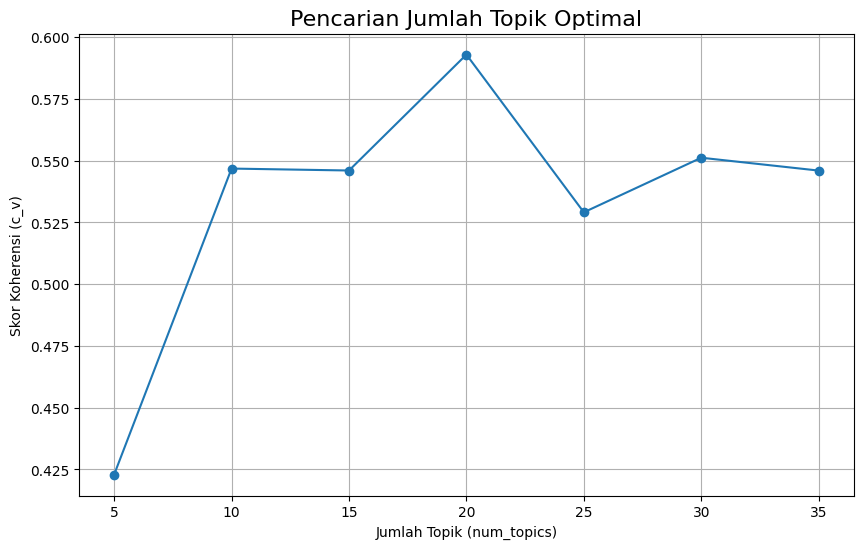


--- Ringkasan Skor Koherensi ---
Jumlah Topik = 5, memiliki Skor Koherensi = 0.4229
Jumlah Topik = 10, memiliki Skor Koherensi = 0.5468
Jumlah Topik = 15, memiliki Skor Koherensi = 0.546
Jumlah Topik = 20, memiliki Skor Koherensi = 0.593
Jumlah Topik = 25, memiliki Skor Koherensi = 0.5291
Jumlah Topik = 30, memiliki Skor Koherensi = 0.5512
Jumlah Topik = 35, memiliki Skor Koherensi = 0.546

✅ Jumlah topik optimal yang ditemukan: 20

--- Melatih model LDA final dengan topik optimal... ---
Ekstraksi fitur LDA selesai.
Bentuk matriks fitur (X): (3653, 20)


In [11]:
## FASE 3: EKSTRAKSI FITUR LDA & PENCARIAN TOPIK OPTIMAL

# Siapkan data untuk Gensim
documents = [doc.split() for doc in df['hasil_preprocessing']]
dictionary = Dictionary(documents)

# --- A. Filter Kamus (Sesuai Referensi & Praktik Terbaik) ---
# Membuang kata yang terlalu jarang atau terlalu sering muncul.
# Ini meningkatkan kualitas topik secara signifikan.
dictionary.filter_extremes(no_below=15, no_above=0.5)
corpus = [dictionary.doc2bow(doc) for doc in documents]
print(f"\nKamus dibuat dan difilter. Jumlah kata unik: {len(dictionary)}")


# --- B. Estimasi Jumlah Topik dengan HDP (Langkah Cerdas) ---
print("\n--- Menjalankan HDP untuk estimasi jumlah topik... ---")
hdp_model = HdpModel(corpus=corpus, id2word=dictionary)
estimated_num_topics = len(hdp_model.print_topics())
print(f"✅ HDP mengestimasi ada sekitar: {estimated_num_topics} topik.")


# --- C. Mencari Jumlah Topik Terbaik dengan Plot Koherensi ---
def compute_coherence_values_multicore(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    start_time = time.time()
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics,
                             random_state=42, passes=10, workers=3)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        current_coherence = coherencemodel.get_coherence()
        coherence_values.append(current_coherence)
        print(f"Selesai menghitung untuk {num_topics} topik. Skor Koherensi: {current_coherence:.4f}")
    total_time = time.time() - start_time
    print(f"\nTotal waktu pencarian koherensi: {total_time/60:.2f} menit")
    return coherence_values

# Atur rentang pencarian di sekitar hasil HDP
search_start = max(2, estimated_num_topics - 15)
search_limit = estimated_num_topics + 20
search_step = 5

print(f"\n--- Menjalankan pencarian koherensi dari {search_start} hingga {search_limit} topik... ---")
coherence_values = compute_coherence_values_multicore(dictionary=dictionary, corpus=corpus, texts=documents,
                                                    start=search_start, limit=search_limit, step=search_step)

# Tampilkan grafik
x = range(search_start, search_limit, search_step)
plt.figure(figsize=(10, 6))
plt.plot(x, coherence_values, marker='o')
plt.title("Pencarian Jumlah Topik Optimal", fontsize=16)
plt.xlabel("Jumlah Topik (num_topics)")
plt.ylabel("Skor Koherensi (c_v)")
plt.xticks(x)
plt.grid(True)
plt.show()

# Tampilkan ringkasan skor koherensi
print("\n--- Ringkasan Skor Koherensi ---")
for num, score in zip(x, coherence_values):
    print(f"Jumlah Topik = {num}, memiliki Skor Koherensi = {round(score, 4)}")

# Pilih jumlah topik terbaik (yang memiliki skor koherensi tertinggi)
optimal_num_topics = x[np.argmax(coherence_values)]
print(f"\n✅ Jumlah topik optimal yang ditemukan: {optimal_num_topics}")


# --- D. Latih Model LDA Final & Ekstrak Fitur ---
print("\n--- Melatih model LDA final dengan topik optimal... ---")
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=optimal_num_topics,
                         random_state=42, passes=15)

# Ekstrak fitur (distribusi topik) untuk setiap dokumen
def get_lda_features(lda_model, bow_corpus):
    features = []
    for doc_bow in bow_corpus:
        topic_distribution = lda_model.get_document_topics(doc_bow, minimum_probability=0)
        doc_features = [0.0] * optimal_num_topics
        for topic_id, prob in topic_distribution:
            doc_features[topic_id] = prob
        features.append(doc_features)
    return np.array(features)

X = get_lda_features(lda_model, corpus)
y = df['kategori'].values

print("Ekstraksi fitur LDA selesai.")
print(f"Bentuk matriks fitur (X): {X.shape}")

In [ ]:
## FASE 4: PELATIHAN DAN EVALUASI MODEL KLASIFIKASI

# --- A. Bagi Data menjadi Latih dan Uji ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nData dibagi. Jumlah data latih: {len(X_train)}, Jumlah data uji: {len(X_test)}")


# --- B. Latih Model Klasifikasi (SVM) ---
# Kita gunakan SVM sesuai hasil eksperimen dan referensi.
classifier = SVC(kernel='linear', random_state=42, probability=True)

print("\n--- Memulai pelatihan model SVM... ---")
classifier.fit(X_train, y_train)
print("Pelatihan selesai.")


# --- C. Evaluasi Kinerja Model ---
y_pred = classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\n--- HASIL EVALUASI AKHIR ---")
print(f"Akurasi Model: {accuracy * 100:.2f}%")
print("\nLaporan Klasifikasi (Classification Report):")
print(classification_report(y_test, y_pred))


Data dibagi. Jumlah data latih: 2922, Jumlah data uji: 731

--- Memulai pelatihan model SVM... ---
Pelatihan selesai.

--- HASIL EVALUASI AKHIR ---
Akurasi Model: 38.03%

Laporan Klasifikasi (Classification Report):
                          precision    recall  f1-score   support

               Birokrasi       0.05      0.05      0.05        20
                   Dunia       0.38      0.25      0.30        20
                 Ekonomi       0.95      1.00      0.98        20
            Entrepreneur       0.21      0.60      0.31        20
                   Figur       0.09      0.05      0.06        20
        Hukum - Kriminal       0.29      0.85      0.43        20
                   Jatim       0.00      0.00      0.00        20
             Jatim Barat       0.15      0.15      0.15        20
            Jatim Madura       0.00      0.00      0.00        20
             Jatim Metro       0.20      0.10      0.13        20
           Jatim Selatan       0.09      0.10      0.09 

c:\Users\Rizky\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Rizky\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Rizky\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave


--- Membuat visualisasi UMAP untuk perbandingan Train vs Test... ---


c:\Users\Rizky\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\Rizky\AppData\Local\Temp\ipykernel_51116\4126789932.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap("Spectral", len(labels))
c:\Users\Rizky\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\collections.py:1112: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


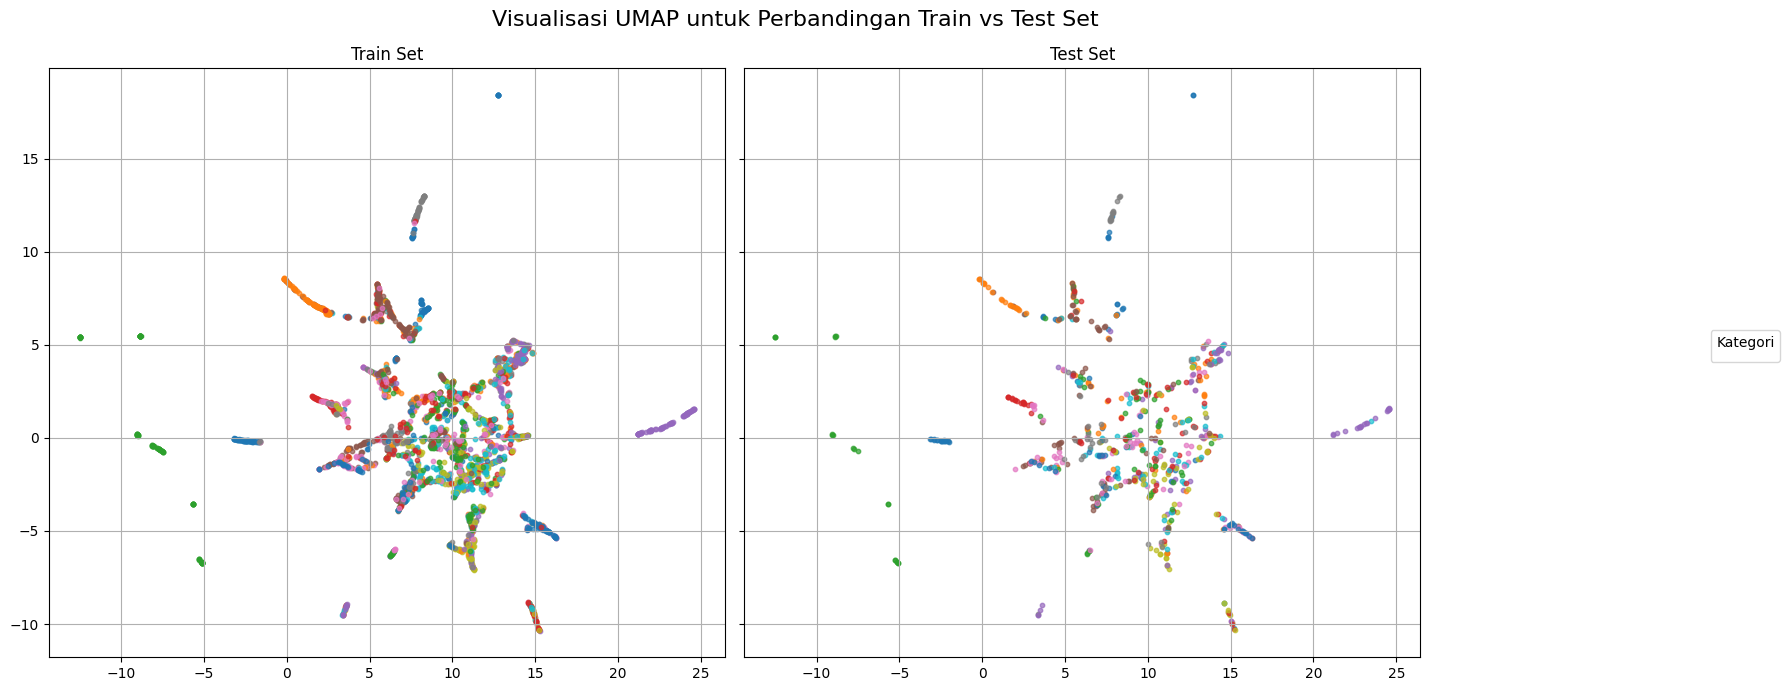


--- Selesai ---


In [ ]:
## FASE 5: ANALISIS LANJUTAN DAN VISUALISASI (UMAP)

print("\n--- Membuat visualisasi UMAP untuk perbandingan Train vs Test... ---")

# --- A. Siapkan Data untuk Visualisasi ---
labels = list(pd.Series(y_train).unique())
label_map = {label: i for i, label in enumerate(labels)}
y_train_numeric = pd.Series(y_train).map(label_map).values
y_test_numeric = pd.Series(y_test).map(label_map).values

# Gabungkan, skalakan, dan terapkan UMAP
X_combined = np.concatenate((X_train, X_test), axis=0)
X_scaled = StandardScaler().fit_transform(X_combined)
reducer = umap.UMAP(n_components=2, random_state=42)
X_2d_combined = reducer.fit_transform(X_scaled)
x2d_train = X_2d_combined[:len(X_train)]
x2d_test = X_2d_combined[len(X_train):]

# --- B. Fungsi untuk Menggambar Plot ---
def plot_topic_clusters(ax, x2d, y_numeric, labels, title):
    ax.set_title(title)
    colors = cm.get_cmap("Spectral", len(labels))
    for i, label_name in enumerate(labels):
        ax.scatter(x2d[y_numeric == i, 0], x2d[y_numeric == i, 1],
                   label=label_name, alpha=0.7, s=10)
    ax.grid(True)
    return ax

# --- C. Buat dan Tampilkan Dua Subplot ---
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharex=True, sharey=True)
plot_topic_clusters(axes[0], x2d_train, y_train_numeric, labels, "Train Set")
plot_topic_clusters(axes[1], x2d_test, y_test_numeric, labels, "Test Set")
fig.suptitle("Visualisasi UMAP untuk Perbandingan Train vs Test Set", fontsize=16)

# Tambahkan legenda di luar plot
handles, current_labels = axes[0].get_legend_handles_labels()
# Gunakan `num` untuk memastikan semua handle dibuat jika kategori banyak
handles, _ = axes[0].collections[0].legend_elements(num=len(labels))
fig.legend(handles, labels, title="Kategori", loc='center right', bbox_to_anchor=(1.12, 0.5))

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

print("\n--- Selesai ---")